In [ ]:
import os
import gensim
from gensim.models import Phrases
import gensim.corpora as corpora
from pprint import pprint

# путь к папке с лемматизированными текстами
# если вы хотите работать из колаба, сначала создайте папку вручную слева, а потом загрузите туда файлы
# либо я могу оформить эту часть как-то иначе, если нужно.
#path = "../corpus_data/SUBCORPORA_LEMMATIZED_POS_FILTERED/"
path = "../ORD/"

# файл со стоп-словарем (можно использовать другой, свой я положила в трелло)
with open('swl_optimum.txt', 'r', encoding='utf-8') as swl_file:
    my_swl = swl_file.readlines()

my_swl = [w.strip() for w in my_swl]
names = {}
# читаем документы из папки
files = os.listdir("/content/LingCorp")
docs = []
id2doc = {}

for i, file in enumerate(files):
    with open("/content/LingCorp/" + file, encoding="utf-8") as text_file:
        text = text_file.read().split()
        text = [word for word in text if not word in my_swl]
        text = [word for word in text if word.isalpha() and len(word) > 2]
        docs.append(text)
        file_id = file.split("_")[0]
        id2doc[i] = file_id
    

files = os.listdir("/content/LingCorp")

# объединение биграмм в тексте
# здесь можно менять параметры! (сколько раз слова встретились вместе, чтобы считаться биграммой)
bigram = Phrases(docs, min_count=4)
bigram_mod = gensim.models.phrases.Phraser(bigram)
docs = [bigram_mod[doc] for doc in docs]

# Подготовка к созданию модели. Создаем словарь при помощи класса Dictionary,
# хранит список токенов, кажому из которых сопоставлен свой id:
id2word = corpora.Dictionary(docs)

# Удаляем слишком редкие и слишком частые слова = встречается не менее чем в 6 документах и
#  не более чем 80% корпуса. Здесь тоже можно менять значения
id2word.filter_extremes(no_below=3, no_above=0.9)

# Term Document Frequency: mapping of (word_id, word_frequency)
corpus = [id2word.doc2bow(text) for text in docs]

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

for doc in docs:
  for word in doc: 
      word = morph.parse(word)[0].normal_form

In [ ]:
# функция, которая будет определять меру связности для разного количества тем с заданным шагом
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                passes = 10,
                                                iterations=100,
                                                eval_every = 1
                                                )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# чтобы видеть, что работа идет
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# вызов функции, которая будет создавать несколько моделей, нужно задать промежуток количества тем и шаг
# это может быть долго
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs, start=5, limit=30, step=5)

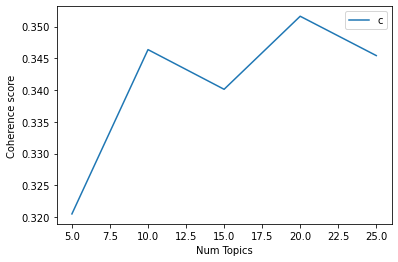

In [ ]:
# Построить график (значения limit, start и step должны совпадать с переданными функции выше)
import matplotlib.pyplot as plt
%matplotlib inline
limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# соответствие количества тем и значения c_v в виде списка (тоже самое, что на графике)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3205
Num Topics = 10  has Coherence Value of 0.3464
Num Topics = 15  has Coherence Value of 0.3401
Num Topics = 20  has Coherence Value of 0.3516
Num Topics = 25  has Coherence Value of 0.3454


In [ ]:
# Выбираем модель по номеру (я выбрала пятую (4), потому что там значение связности самое высокое.)
optimal_model = model_list[4]
model_topics = optimal_model.print_topics(-1, num_words=20)
pprint(model_topics)

[(0,
  '0.028*"языков" + 0.019*"языки" + 0.015*"глагола" + 0.014*"других" + '
  '0.010*"слова" + 0.009*"которые" + 0.009*"языке" + 0.009*"является" + '
  '0.008*"была" + 0.008*"отсутствие" + 0.008*"языка" + 0.008*"конструкции" + '
  '0.008*"морфологических" + 0.008*"языках" + 0.008*"язык" + '
  '0.007*"предложения" + 0.007*"грамматических" + 0.007*"противопоставление" + '
  '0.006*"времени" + 0.006*"лингвистической"'),
 (1,
  '0.003*"слово" + 0.003*"слова" + 0.002*"слов" + 0.002*"языке" + '
  '0.002*"имена" + 0.002*"языка" + 0.002*"язык" + 0.002*"были" + '
  '0.002*"русском_языке" + 0.002*"собой" + 0.002*"русского" + 0.002*"всех" + '
  '0.002*"является" + 0.001*"имен" + 0.001*"был" + 0.001*"языком" + '
  '0.001*"русских" + 0.001*"значение" + 0.001*"таких" + 0.001*"быть"'),
 (2,
  '0.003*"слова" + 0.002*"слово" + 0.002*"языка" + 0.002*"является" + '
  '0.002*"языке" + 0.002*"этом" + 0.002*"языков" + 0.002*"слов" + 0.002*"язык" '
  '+ 0.002*"которые" + 0.002*"имена" + 0.002*"языках" + 0.

In [ ]:
import pandas as pd
topic_words = {"topic_num": [], "topic_name": [], "topic_words": []}

for i, top in model_topics:
    topic_words["topic_num"].append(i)
    topic_words["topic_name"].append(i)
    topic_words["topic_words"].append(optimal_model.show_topic(i))

topic_words_df = pd.DataFrame.from_dict(topic_words)
topic_words_df.to_csv("topic_words.csv")

In [ ]:
labels_data = pd.read_csv("topic_words.csv")
# topic_labels = labels_data[["topic_name"]]
topic_labels = {}
topic2name = (dict(zip(labels_data.topic_num, labels_data.topic_name)))
topic2name

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19}

In [ ]:
# topic2name = {}
# all_topics = []
# for topic in optimal_model.print_topics():
#     label = input(topic[1] + "\nEnter topic name or skip: ")
#     if label:
#         topic2name[topic[0]] = label
#
# print(topic2name)


In [ ]:
def get_words_for_topic(model, i):
    words = []
    for w, prob in model.show_topic(i):
        words.append(w)
    return words


IndexError: ignored

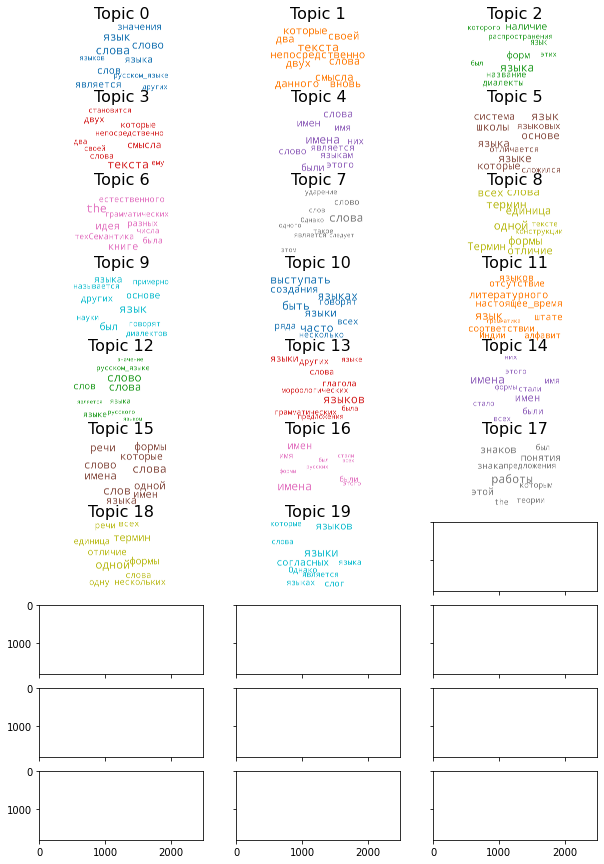

In [ ]:
# еще немного визуализации
# тут тоже нужно немного менять настройки в зависимости от количества тем (num_topics и plt.subplots(10, 3, figsize=(10,40))
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in list(mcolors.TABLEAU_COLORS.items()) * 4]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=my_swl,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(num_topics=30, formatted=False)

fig, axes = plt.subplots(10, 3, figsize=(10,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

# сохраняем картинку в хорошем разрешении (мало ли)
plt.savefig("topics.png", dpi=100)
plt.show()